# Laba 2

## Наивный алгоритм

In [129]:
import pandas as pd
import numpy as np
import random
import graphblas as gb
from graphblas import Matrix, Vector
from graphblas import dtypes
from graphblas import binary, monoid, semiring
from graphblas.io import mmread
import time
import os

## #1 MSBFS-Levels

In [130]:
def MSBFS_Levels(A, start_vertex):
    n = A.nrows
    m = start_vertex.size
    main_matrix = Matrix(dtypes.INT64, m, n)
    f = Matrix(bool, m, n)
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i,start_vertex[i]] << True
    level=0
    
    while True:
        main_matrix(mask=f.V) << level
        f(~main_matrix.S, replace=True) << f.mxm(A, semiring.lor_land)
        for i in range(m):
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
        flag = True
        for i in range(m):
            if succ[i]:
                flag = False
                break
        if flag == True:
            break
        level += 1
        
    result = {}
    for i in range(m):
        res=[]
        for j in range(n):
            if main_matrix[i,j].value is None:
                res.append(-1)
            else:
                res.append(main_matrix[i,j].value)
        result[start_vertex[i]]=np.array(res)
    return result

## #2 MSBFS-Parents

In [131]:
def MSBFS_Parents(A, start_vertex): 
    n = A.nrows
    m = start_vertex.size
    index_ramp = Matrix(dtypes.UINT64, m, n)
    
    for i in range(m):
        for j in range(n):
            index_ramp[i,j] << j
            
    parents = Matrix(dtypes.UINT64, m, n)
    front = Matrix(dtypes.UINT64, m, n)
    
    for i in range(m):
        parents[i,start_vertex[i]] << start_vertex[i]
        front[i, start_vertex[i]] << 1

    while front.nvals > 0:
        front << index_ramp.ewise_mult(front, binary.first)
        front(~parents.S, replace=True) << front.mxm(A, semiring.min_first)
        parents(binary.plus) << front
    
    result = {}
    for i in range(m):
        res=[]
        for j in range(n):
            if parents[i,j].value is None:
                res.append(-2)
            elif j==start_vertex[i]:
                res.append(-1)
            else:
                res.append(parents[i,j].value)
        result[start_vertex[i]]=np.array(res)
    return result

## #3 Тесты

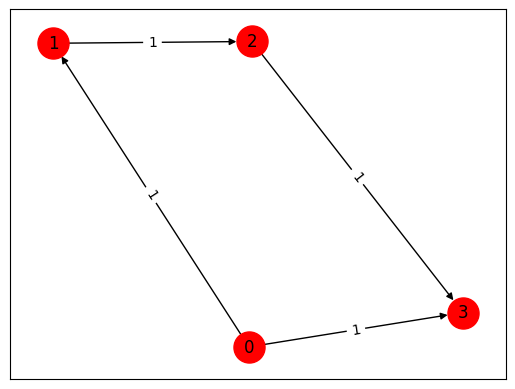

In [132]:
M1 = np.array([
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
    ])

M1 = gb.Matrix.from_dense(M1, missing_value=0)
gb.viz.draw(M1)

In [133]:
MSBFS_Levels(M1, np.array([0, 1, 2, 3]))
# 0: 0, 1, 2, 1
# 1: -1, 0, 1, 2
# 2: -1, -1, 0, 1
# 3: -1, -1, -1, 0

{0: array([0, 1, 2, 1]),
 1: array([-1,  0,  1,  2]),
 2: array([-1, -1,  0,  1]),
 3: array([-1, -1, -1,  0])}

In [134]:
MSBFS_Parents(M1, np.array([0, 1, 2, 3]))
# 0: -1, 0, 1, 0
# 1: -2, -1, 1, 2
# 2: -2, -2, -1, 2
# 3: -2, -2, -2, -1

{0: array([-1,  0,  1,  0]),
 1: array([-2, -1,  1,  2]),
 2: array([-2, -2, -1,  2]),
 3: array([-2, -2, -2, -1])}

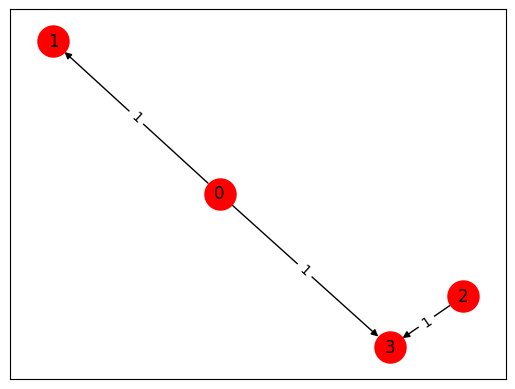

In [135]:
M2 = np.array([
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
    ])

M2 = gb.Matrix.from_dense(M2, missing_value=0)
gb.viz.draw(M2)

In [136]:
MSBFS_Levels(M2, np.array([0, 1, 2, 3]))
# 0: 0, 1, -1, 1
# -1: 0, 0, -1, -1
# 2: -1, -1, 0, 1
# 3: -1, -1, -1, 0

{0: array([ 0,  1, -1,  1]),
 1: array([-1,  0, -1, -1]),
 2: array([-1, -1,  0,  1]),
 3: array([-1, -1, -1,  0])}

In [137]:
MSBFS_Parents(M2, np.array([0, 1, 2, 3]))
# 0: -1, 0, -2, 0
# 1: -2, -1, -2, -2
# 2: -2, -2, -1, 2
# 3: -2, -2, -2, -1

{0: array([-1,  0, -2,  0]),
 1: array([-2, -1, -2, -2]),
 2: array([-2, -2, -1,  2]),
 3: array([-2, -2, -2, -1])}

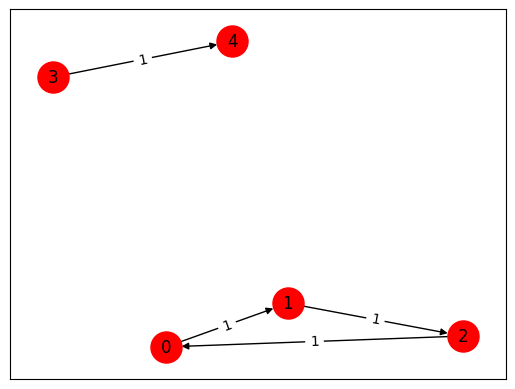

In [138]:
M3 = np.array([
    [0,	1, 0, 0, 0],
    [0,	0, 1, 0, 0],
    [1,	0, 0, 0, 0],
    [0,	0, 0, 0, 1],
    [0,	0, 0, 0, 0]
    ])

M3 = gb.Matrix.from_dense(M3, missing_value=0)
gb.viz.draw(M3)

In [139]:
MSBFS_Levels(M3, np.array([0, 1, 2, 3, 4]))
# 0: 0, 1, 2, -1, -1
# -1: 2, 0, 1, -1, -1
# 2: 1, 2, 0, -1, -1
# 3: -1, -1, -1, 0, 1
# 4: -1, -1, -1, -1, 0

{0: array([ 0,  1,  2, -1, -1]),
 1: array([ 2,  0,  1, -1, -1]),
 2: array([ 1,  2,  0, -1, -1]),
 3: array([-1, -1, -1,  0,  1]),
 4: array([-1, -1, -1, -1,  0])}

In [140]:
MSBFS_Parents(M3, np.array([0, 1, 2, 3, 4]))
# 0: -1, 0, 1, -1, -2
# 1: 2, -1, 1, -2, -2
# 2: 2, 0, -1, -2, -2
# 3: -2, -2, -2, -1, 3
# 4: -2, -2, -2, -2, -1

{0: array([-1,  0,  1, -2, -2]),
 1: array([ 2, -1,  1, -2, -2]),
 2: array([ 2,  0, -1, -2, -2]),
 3: array([-2, -2, -2, -1,  3]),
 4: array([-2, -2, -2, -2, -1])}

## #4 Тестирование

## графы с сайта https://sparse.tamu.edu/

In [141]:
def test_MSBFS_Levels(A, start_vertices):
    start = time.time()
    MSBFS_Levels(A, start_vertices)
    end = time.time()
    working_time = (end-start)
    return working_time


In [142]:
def test_MSBFS_Parents(A, start_vertices):
    start = time.time()
    MSBFS_Parents(A, start_vertices)
    end = time.time()
    working_time = (end-start)
    return working_time

In [143]:
def generation_start_vertices(num_vertices, frequency):
    start_vertices = random.sample(range(num_vertices), int(num_vertices * frequency/100))
    return np.array(start_vertices)

In [144]:
vertex_frequency=[5, 20, 80]

In [ ]:
graphs_metrics_levels = pd.DataFrame(columns=['Файл', 'Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Время'])
graph_names = os.listdir('graphs2')
for graph_name in graph_names:
    graph = mmread(f'graphs2/{graph_name}')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    for vertex_freq in vertex_frequency:
        working_time = test_MSBFS_Levels(graph, generation_start_vertices(graph.nrows, vertex_freq))
        graphs_metrics_levels.loc[len(graphs_metrics_levels)] = graph_name, num_vertices, rerefaction_deg, int(vertex_freq/100 * graph.nrows), working_time

In [149]:
graphs_metrics_levels

,Файл,Количество вершин,Степень разреженности,Количество стартовых вершин,Время
0,EPA.mtx,4772,0.000394,238,28.411839
1,EPA.mtx,4772,0.000394,954,104.318699
2,EPA.mtx,4772,0.000394,3817,411.587476
3,GD06_Java.mtx,1538,0.003398,76,3.689158
4,GD06_Java.mtx,1538,0.003398,307,14.193957
5,GD06_Java.mtx,1538,0.003398,1230,60.045781


In [150]:
graphs_metrics_parents = pd.DataFrame(columns=['Файл', 'Количество вершин', 'Степень разреженности', 'Количество стартовых вершин', 'Время'])
graph_names = os.listdir('graphs2')
for graph_name in graph_names:
    graph = mmread(f'graphs2/{graph_name}')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    for vertex_freq in vertex_frequency:
        working_time = test_MSBFS_Parents(graph, generation_start_vertices(graph.nrows, vertex_freq))
        graphs_metrics_parents.loc[len(graphs_metrics_parents)] = graph_name, num_vertices, rerefaction_deg, int(vertex_freq/100 * graph.nrows), working_time

In [151]:
graphs_metrics_parents

,Файл,Количество вершин,Степень разреженности,Количество стартовых вершин,Время
0,EPA.mtx,4772,0.000394,238,41.738031
1,EPA.mtx,4772,0.000394,954,174.331909
2,EPA.mtx,4772,0.000394,3817,671.154847
3,GD06_Java.mtx,1538,0.003398,76,6.883207
4,GD06_Java.mtx,1538,0.003398,307,23.991821
5,GD06_Java.mtx,1538,0.003398,1230,85.546768


## Генерация случайных графов

In [152]:
# Функция генерации случайного графа
def generate_graph(num_vertices, num_edges):
    positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)
    gen_index = random.sample(positions, num_edges)
    row_index, col_index = np.unravel_index(gen_index, (num_vertices, num_vertices))
    
    return gb.Matrix.from_coo(row_index, col_index, [1]*len(row_index), nrows=num_vertices, ncols=num_vertices)

Зависимость от числа вершин

In [194]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [100, 200, 400, 600, 800]:
    fix_raref_deg, share_starts = 0.5, 40 
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    lev = test_MSBFS_Levels(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'MSBFS_Levels', lev

    par = test_MSBFS_Parents(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'MSBFS_Parents', par

In [195]:
graphs_gen_metrics['Время/Кол-во вершин'] = graphs_gen_metrics['Время']/graphs_gen_metrics['Количество вершин']
graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время,Время/Кол-во вершин
0,100,0.5,40,MSBFS_Levels,0.224971,0.002250
2,200,0.5,40,MSBFS_Levels,0.790644,0.003953
4,400,0.5,40,MSBFS_Levels,3.179439,0.007949
6,600,0.5,40,MSBFS_Levels,9.824543,0.016374
8,800,0.5,40,MSBFS_Levels,13.012024,0.016265
1,100,0.5,40,MSBFS_Parents,0.246351,0.002464
3,200,0.5,40,MSBFS_Parents,1.194520,0.005973
5,400,0.5,40,MSBFS_Parents,5.502334,0.013756
7,600,0.5,40,MSBFS_Parents,10.004277,0.016674
9,800,0.5,40,MSBFS_Parents,15.938192,0.019923


Зависимость от разреженности графа

In [171]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [0.2, 0.5, 0.7]:
    num_vert, share_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    
    lev = test_MSBFS_Levels(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, i, share_starts, 'MSBFS_Levels', lev

    par = test_MSBFS_Parents(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, i, share_starts, 'MSBFS_Parents', par

In [172]:
graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время
0,500,0.2,50,MSBFS_Levels,8.100761
2,500,0.5,50,MSBFS_Levels,6.404587
4,500,0.7,50,MSBFS_Levels,6.564165
1,500,0.2,50,MSBFS_Parents,8.162150
3,500,0.5,50,MSBFS_Parents,8.133233
5,500,0.7,50,MSBFS_Parents,7.693569


Зависимость от числа стартовых вершин

In [174]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    lev = test_MSBFS_Levels(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, fix_raref_deg, i, 'MSBFS_Levels', lev

    par = test_MSBFS_Parents(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, fix_raref_deg, i, 'MSBFS_Parents', par

In [175]:
graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время
0,500,0.5,20,MSBFS_Levels,3.020351
2,500,0.5,40,MSBFS_Levels,5.235357
4,500,0.5,60,MSBFS_Levels,7.677547
6,500,0.5,80,MSBFS_Levels,10.656242
1,500,0.5,20,MSBFS_Parents,3.454898
3,500,0.5,40,MSBFS_Parents,7.517921
5,500,0.5,60,MSBFS_Parents,9.042201
7,500,0.5,80,MSBFS_Parents,14.028180


Выводы:

При увеличении количества стартовых вершин при неизменных других параметрах, время увеличивается (В случае с MSBFS_Levels ~линейно; в случае с MSBFS_Parents -- нелинейная зависимость)

При увеличении количества вершин графа время увеличивается, однако скорость изменения имеет степенную функцию

Степень разреженности графа не влияет на время выполнения работы

# Реализация алгоритмов с использованием других полуколец

In [183]:
def MSBFS_Levels_any_pair(A, start_vertex):
    n = A.nrows
    m = start_vertex.size
    main_matrix = Matrix(dtypes.INT64, m, n)
    f = Matrix(bool, m, n)
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i,start_vertex[i]] << True
    level=0
    
    while True:
        main_matrix(mask=f.V) << level
        f(~main_matrix.S, replace=True) << f.mxm(A, semiring.any_pair) # поменяли на any_pair
        for i in range(m):
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
        flag = True
        for i in range(m):
            if succ[i]:
                flag = False
                break
        if flag == True:
            break
        level += 1
        
    result = {}
    for i in range(m):
        res=[]
        for j in range(n):
            if main_matrix[i,j].value is None:
                res.append(-1)
            else:
                res.append(main_matrix[i,j].value)
        result[start_vertex[i]]=np.array(res)
    return result

In [184]:
def MSBFS_Parents_any_first(A, start_vertex): 
    n = A.nrows
    m = start_vertex.size
    index_ramp = Matrix(dtypes.UINT64, m, n)
    
    for i in range(m):
        for j in range(n):
            index_ramp[i,j] << j
            
    parents = Matrix(dtypes.UINT64, m, n)
    front = Matrix(dtypes.UINT64, m, n)
    
    for i in range(m):
        parents[i,start_vertex[i]] << start_vertex[i]
        front[i, start_vertex[i]] << 1

    while front.nvals > 0:
        front << index_ramp.ewise_mult(front, binary.first)
        front(~parents.S, replace=True) << front.mxm(A, semiring.any_first) # поменяли на any_first
        parents(binary.plus) << front
    
    result = {}
    for i in range(m):
        res=[]
        for j in range(n):
            if parents[i,j].value is None:
                res.append(-2)
            elif j==start_vertex[i]:
                res.append(-1)
            else:
                res.append(parents[i,j].value)
        result[start_vertex[i]]=np.array(res)
    return result

## Тестирование

In [185]:
def test_MSBFS_Levels_any_pair(A, start_vertices):
    start = time.time()
    MSBFS_Levels_any_pair(A, start_vertices)
    end = time.time()
    working_time = (end-start)
    return working_time

def test_MSBFS_Parents_any_first(A, start_vertices):
    start = time.time()
    MSBFS_Parents_any_first(A, start_vertices)
    end = time.time()
    working_time = (end-start)
    return working_time


Количество вершин

In [192]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [100, 200, 400, 800]:
    fix_raref_deg, share_starts = 0.5, 20 
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    lev = test_MSBFS_Levels_any_pair(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'MSBFS_Levels_any_pair', lev

    par = test_MSBFS_Parents_any_first(generated_graph, generation_start_vertices(i, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = i, fix_raref_deg, share_starts, 'MSBFS_Parents_any_first', par

graphs_gen_metrics['Время/Кол-во вершин'] = graphs_gen_metrics['Время']/graphs_gen_metrics['Количество вершин']
graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время,Время/Кол-во вершин
0,100,0.5,20,MSBFS_Levels_any_pair,0.149542,0.001495
2,200,0.5,20,MSBFS_Levels_any_pair,0.388767,0.001944
4,400,0.5,20,MSBFS_Levels_any_pair,1.944448,0.004861
6,800,0.5,20,MSBFS_Levels_any_pair,7.044581,0.008806
1,100,0.5,20,MSBFS_Parents_any_first,0.122832,0.001228
3,200,0.5,20,MSBFS_Parents_any_first,0.677670,0.003388
5,400,0.5,20,MSBFS_Parents_any_first,2.036283,0.005091
7,800,0.5,20,MSBFS_Parents_any_first,10.020795,0.012526


Разреженность графа

In [188]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [0.2, 0.3, 0.5, 0.7, 0.9]:
    num_vert, share_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    
    lev = test_MSBFS_Levels_any_pair(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, i, share_starts, 'MSBFS_Levels_any_pair', lev

    par = test_MSBFS_Parents_any_first(generated_graph, generation_start_vertices(num_vert, share_starts))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, i, share_starts, 'MSBFS_Parents_any_first', par

graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время
0,500,0.2,50,MSBFS_Levels_any_pair,6.815878
2,500,0.3,50,MSBFS_Levels_any_pair,7.316448
4,500,0.5,50,MSBFS_Levels_any_pair,6.594696
6,500,0.7,50,MSBFS_Levels_any_pair,8.767396
8,500,0.9,50,MSBFS_Levels_any_pair,6.025644
1,500,0.2,50,MSBFS_Parents_any_first,8.180184
3,500,0.3,50,MSBFS_Parents_any_first,8.790040
5,500,0.5,50,MSBFS_Parents_any_first,8.403567
7,500,0.7,50,MSBFS_Parents_any_first,8.179916
9,500,0.9,50,MSBFS_Parents_any_first,7.586289


Доля стартовых вершин

In [189]:
graphs_gen_metrics = pd.DataFrame(columns=['Количество вершин', 'Степень разреженности', 'Доля стартовых вершин', 'Функция', 'Время'])
for i in [5, 20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))

    lev = test_MSBFS_Levels_any_pair(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, fix_raref_deg, i, 'MSBFS_Levels_any_pair', lev

    par = test_MSBFS_Parents_any_first(generated_graph, generation_start_vertices(num_vert, i))
    graphs_gen_metrics.loc[len(graphs_gen_metrics)] = num_vert, fix_raref_deg, i, 'MSBFS_Parents_any_first', par

graphs_gen_metrics.sort_values('Функция')

,Количество вершин,Степень разреженности,Доля стартовых вершин,Функция,Время
0,500,0.5,5,MSBFS_Levels_any_pair,0.609943
2,500,0.5,20,MSBFS_Levels_any_pair,2.401059
4,500,0.5,40,MSBFS_Levels_any_pair,4.717482
6,500,0.5,60,MSBFS_Levels_any_pair,7.970346
8,500,0.5,80,MSBFS_Levels_any_pair,9.360382
1,500,0.5,5,MSBFS_Parents_any_first,0.767316
3,500,0.5,20,MSBFS_Parents_any_first,3.358292
5,500,0.5,40,MSBFS_Parents_any_first,6.216554
7,500,0.5,60,MSBFS_Parents_any_first,9.525683
9,500,0.5,80,MSBFS_Parents_any_first,12.881779


Выводы:

При увеличении размера графа, время увеличивается нелинейно (степенная функция)

Разреженность графа не влияет на время работы алгоритмов 

При увеличении доли стартовых вершин время работы увеличивается ~ линейно